In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
# --- 1. Define Player Pools ---
# The OBPs for the core 9 players (your original lineup A)
core_9_players_obps = [
    0.545, 0.545, 0.538, 0.5, 0.462, 0.455, 0.455, 0.455, 0.429,
]

num_simulations = 25000 # Number of games to simulate
effective_PAs = 25     # This parameter controls the uncertainty in OBP.
                       # Lower value (e.g., 25 for kids) = more uncertainty (wider OBP distribution).
num_innings = 9

# The OBPs for the 3 additional players (lower OBP as specified)
additional_3_players_obps = [0.4, 0.364, 0.333]

# --- Define Teams to Compare ---
# Team A: The 9-player lineup
team_A_base_lineup = core_9_players_obps

# Team B: The 12-player lineup (core 9 + additional 3)
team_B_base_lineup = core_9_players_obps + additional_3_players_obps

# --- Define Opponent Lineup (Fixed for Fair Comparison) ---
# An average opponent for consistent comparison
opponent_lineup_obps_nominal = core_9_players_obps

# --- 2. Define Different Lineup Orderings for Each Team Size ---
def get_lineup_orderings(base_obps):
    """Generates different lineup orderings for a given set of player OBPs."""
    sorted_obps_desc = sorted(base_obps, reverse=True)
    sorted_obps_asc = sorted(base_obps)
    
    # "Original/Custom Order" is simply the base_obps as provided
    custom_order = list(base_obps) 

    # "Two Stronger, One Weaker" (2S1W) strategy
    lineup_2s1w = []
    # Create a mutable copy of the sorted players to draw from
    available_players = sorted(base_obps, reverse=True) 
    
    while available_players:
        # Pick 2 strongest
        for _ in range(min(2, len(available_players))):
            lineup_2s1w.append(available_players.pop(0)) # Remove strongest available

        # Pick 1 weakest (from remaining players)
        if available_players: # Ensure there's a weakest to pick
            lineup_2s1w.append(available_players.pop(-1)) # Remove weakest available
    
    return {
        "Descending OBP": sorted_obps_desc,
        "Ascending OBP": sorted_obps_asc,
        "Original/Custom Order": custom_order,
        "2 Stronger, 1 Weaker": lineup_2s1w,
        "Random Order": list(base_obps) # For random order, we just give the base list; it will be shuffled per game
    }


team_A_lineup_options = get_lineup_orderings(team_A_base_lineup)
team_B_lineup_options = get_lineup_orderings(team_B_base_lineup)

# Combine all options for easier iteration
all_team_lineup_options = {
    "Team A (9 Players)": team_A_lineup_options,
    "Team B (12 Players)": team_B_lineup_options
}


Running 25000 simulations for each team size and lineup order...
OBP Uncertainty modeled with effective_PAs = 25 (reflecting lower sample size for kids).
Games are 9 innings and can end in a tie.

### Simulating for: Team A (9 Players) ###
  Nominal Average OBP of Roster: 0.487

--- Lineup Order: Descending OBP ---
  Average Runs Scored: 7.81
  Win Percentage: 47.43%
  Tie Percentage: 5.81%
  Nominal Lineup: 0.545, 0.545, 0.538, 0.500, 0.462, 0.455, 0.455, 0.455, 0.429

--- Lineup Order: Ascending OBP ---
  Average Runs Scored: 7.67
  Win Percentage: 46.41%
  Tie Percentage: 5.88%
  Nominal Lineup: 0.429, 0.455, 0.455, 0.455, 0.462, 0.500, 0.538, 0.545, 0.545

--- Lineup Order: Original/Custom Order ---
  Average Runs Scored: 7.81
  Win Percentage: 46.78%
  Tie Percentage: 5.58%
  Nominal Lineup: 0.545, 0.545, 0.538, 0.500, 0.462, 0.455, 0.455, 0.455, 0.429

--- Lineup Order: 2 Stronger, 1 Weaker ---
  Average Runs Scored: 7.79
  Win Percentage: 47.28%
  Tie Percentage: 6.01%
  Nomina

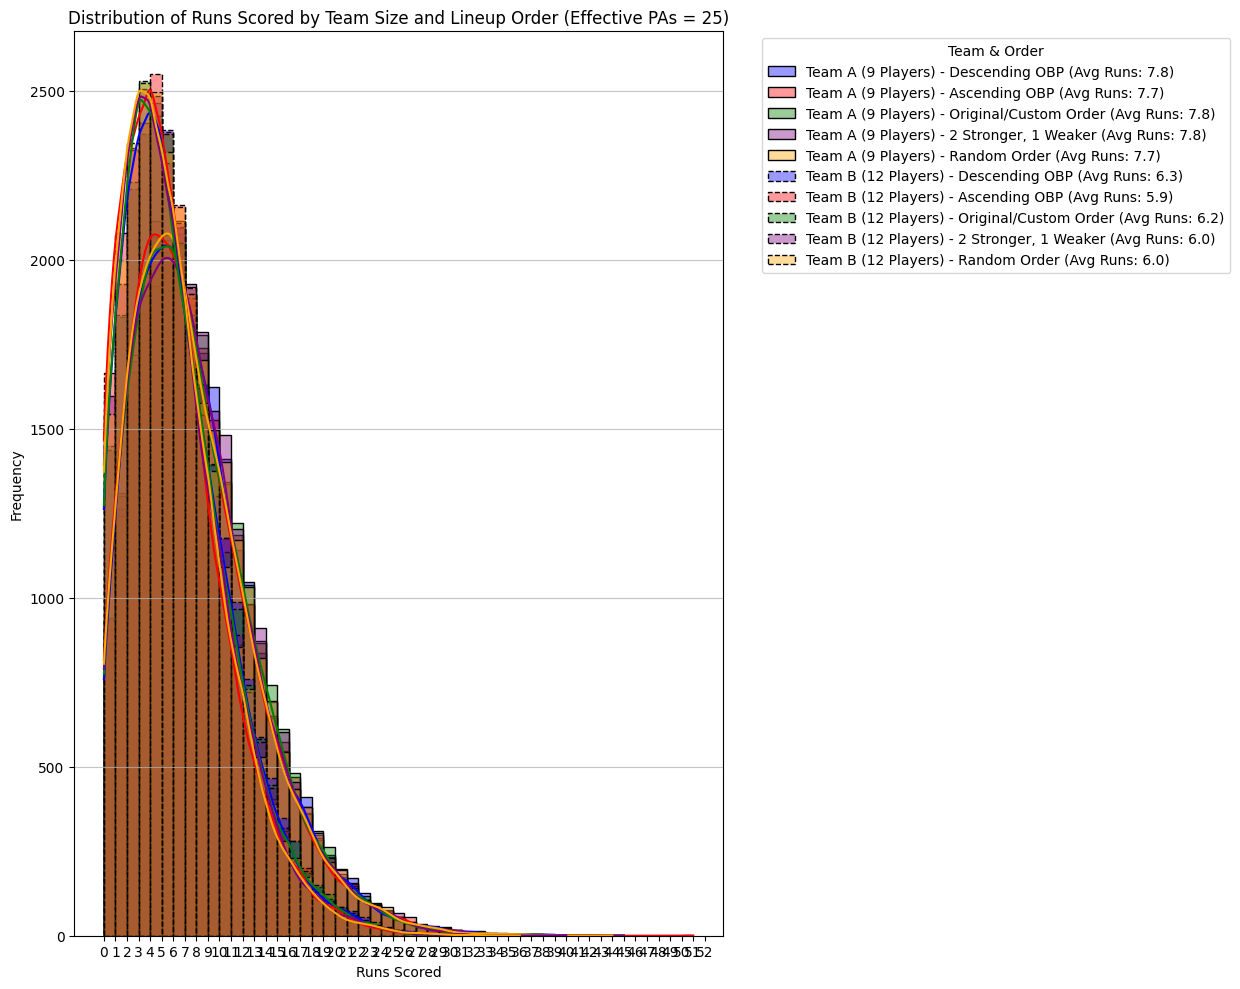

In [33]:
# --- 2. Simplified At-Bat Simulation (No Change) ---
def simulate_at_bat_obp(player_obp):
    """
    Simulates a single at-bat based on On-Base Percentage (OBP).
    Returns 'ON_BASE' if successful, 'OUT' otherwise.
    """
    if random.random() < player_obp:
        return 'ON_BASE'
    else:
        return 'OUT'

# --- 3. Simplified Inning Simulation (OBP only - No Change Needed, adapts to lineup length) ---
def simulate_inning_obp(batting_lineup_obps, current_batter_idx):
    """
    Simulates a single half-inning for a team using OBP-only logic.
    Simplified base running: any 'ON_BASE' event advances all runners one base,
    and a runner on 3rd scores.

    Args:
        batting_lineup_obps (list): List of OBPs for the team's lineup.
        current_batter_idx (int): Index of the player currently up to bat.

    Returns:
        tuple: (runs_scored_this_inning, next_batter_idx)
    """
    runs_scored_this_inning = 0
    outs = 0
    # Bases: [runner_on_1st, runner_on_2nd, runner_on_3rd] (0=empty, 1=runner)
    bases = [0, 0, 0]

    num_players_in_lineup = len(batting_lineup_obps) # This dynamically adjusts to 9 or 12

    while outs < 3:
        # Get the OBP for the current batter in the lineup, cycling through the lineup
        player_obp = batting_lineup_obps[current_batter_idx % num_players_in_lineup]
        outcome = simulate_at_bat_obp(player_obp)

        if outcome == 'OUT':
            outs += 1
            # If a double play or pickoff happens, you'd add more logic here.
            # For OBP only, it's just one out per 'OUT' event.
        else: # outcome == 'ON_BASE'
            # Advance runners according to our simplified rules
            if bases[2] == 1: # Runner on 3rd scores
                runs_scored_this_inning += 1
            bases[2] = bases[1] # Runner on 2nd moves to 3rd
            bases[1] = bases[0] # Runner on 1st moves to 2nd
            bases[0] = 1        # Batter goes to 1st

        current_batter_idx += 1

    return runs_scored_this_inning, current_batter_idx

# --- 5. Helper Function for Single Game Simulation with Actual OBPs ---
def _simulate_single_game_with_actual_obps(team_a_actual_obps, team_b_actual_obps, num_innings):
    """
    Simulates a single baseball game given the actual, game-specific OBPs for both teams.
    Games end after num_innings, no extra innings.
    """
    team_a_score = 0
    team_b_score = 0

    a_batter_idx = 0
    b_batter_idx = 0

    for _ in range(num_innings):
        # Top of the inning (Team A bats)
        runs_a, a_batter_idx = simulate_inning_obp(team_a_actual_obps, a_batter_idx)
        team_a_score += runs_a

        # Bottom of the inning (Team B bats)
        runs_b, b_batter_idx = simulate_inning_obp(team_b_actual_obps, b_batter_idx)
        team_b_score += runs_b
    
    return team_a_score, team_b_score

# --- 6. Main Simulation Loop ---
all_results = {}

print(f"\nRunning {num_simulations} simulations for each team size and lineup order...")
print(f"OBP Uncertainty modeled with effective_PAs = {effective_PAs} (reflecting lower sample size for kids).")
print(f"Games are {num_innings} innings and can end in a tie.")


for team_label, lineup_options_for_team in all_team_lineup_options.items():
    all_results[team_label] = {}
    
    print(f"\n### Simulating for: {team_label} ###")
    # Display nominal average OBP for the team's base roster
    base_nominal_obps = team_A_base_lineup if "9 Players" in team_label else team_B_base_lineup
    print(f"  Nominal Average OBP of Roster: {np.mean(base_nominal_obps):.3f}")

    for lineup_name, nominal_lineup_config_obps in lineup_options_for_team.items():
        # Skip if lineup is empty due to an edge case in construction 
        if not nominal_lineup_config_obps:
            print(f"  Skipping {lineup_name} for {team_label} due to invalid lineup construction.")
            continue

        team_analysed_wins = 0
        team_analysed_ties = 0 
        team_analysed_scores = []
        
        print(f"\n--- Lineup Order: {lineup_name} ---")
        for _ in range(num_simulations):
            # Step 1: Draw actual OBP values for THIS game from Beta distributions
            game_lineup_analysed_obps_actual = []
            for p_nominal in nominal_lineup_config_obps: # Use the nominal order defined for this lineup type
                alpha = p_nominal * effective_PAs + 1
                beta = (1 - p_nominal) * effective_PAs + 1
                game_lineup_analysed_obps_actual.append(np.random.beta(alpha, beta))
            
            game_lineup_opponent_obps_actual = []
            for p_nominal in opponent_lineup_obps_nominal:
                alpha = p_nominal * effective_PAs + 1
                beta = (1 - p_nominal) * effective_PAs + 1
                game_lineup_opponent_obps_actual.append(np.random.beta(alpha, beta))

            # Step 2: If this is the "Random Order" strategy, shuffle the actual OBPs for the analyzed team
            if lineup_name == "Random Order":
                random.shuffle(game_lineup_analysed_obps_actual)

            # Step 3: Simulate the game with these game-specific (and potentially shuffled) actual OBPs
            score_analysed, score_opponent = _simulate_single_game_with_actual_obps(
                game_lineup_analysed_obps_actual, 
                game_lineup_opponent_obps_actual, 
                num_innings
            )
            
            team_analysed_scores.append(score_analysed)

            if score_analysed > score_opponent:
                team_analysed_wins += 1
            elif score_analysed == score_opponent: 
                team_analysed_ties += 1

        all_results[team_label][lineup_name] = {
            'avg_score': np.mean(team_analysed_scores),
            'median_score': np.median(team_analysed_scores),
            'win_percentage': team_analysed_wins / num_simulations,
            'tie_percentage': team_analysed_ties / num_simulations,
            'score_distribution': team_analysed_scores
        }

        print(f"  Average Runs Scored: {all_results[team_label][lineup_name]['avg_score']:.2f}")
        print(f"  Win Percentage: {all_results[team_label][lineup_name]['win_percentage']:.2%}")
        print(f"  Tie Percentage: {all_results[team_label][lineup_name]['tie_percentage']:.2%}")
        # Display the nominal lineup (before any per-game shuffling for 'Random Order') for context
        print(f"  Nominal Lineup: {', '.join(f'{o:.3f}' for o in nominal_lineup_config_obps)}")


# --- Display Comprehensive Comparative Results in a Table ---
print("\n\n--- Comprehensive Comparative Results (with OBP Uncertainty - Effective PAs = 25) ---")
print("{:<25} {:<20} {:<15} {:<15} {:<15}".format("Team & Lineup Order", "Nominal Avg OBP", "Avg Runs Scored", "Win %", "Tie %"))
print("-" * 90)

for team_label, team_results in all_results.items():
    for lineup_name, data in team_results.items():
        if not data: # Skip if data is empty due to a skipped lineup
            continue
        # Get the nominal OBPs for calculating nominal average OBP for display
        current_lineup_obps_nominal = all_team_lineup_options[team_label][lineup_name]
        nominal_lineup_avg_obp = np.mean(current_lineup_obps_nominal)

        print("{:<25} {:<20.3f} {:<15.2f} {:<15.2%} {:<15.2%}".format(
            f"{team_label} ({lineup_name})",
            nominal_lineup_avg_obp,
            data['avg_score'],
            data['win_percentage'],
            data['tie_percentage']
        ))

# --- Visualize Results ---
plt.figure(figsize=(16, 10))
# Define consistent colors and line styles for better comparison across plots
plot_colors = {'Descending OBP': 'blue', 'Ascending OBP': 'red', 'Original/Custom Order': 'green', '2 Stronger, 1 Weaker': 'purple', 'Random Order': 'orange'}
plot_line_styles = {'Team A (9 Players)': '-', 'Team B (12 Players)': '--'}

for team_label, team_data in all_results.items():
    for lineup_name, data in team_data.items():
        if not data: # Skip if data is empty
            continue
        label = f"{team_label} - {lineup_name} (Avg Runs: {data['avg_score']:.1f})"
        sns.histplot(data['score_distribution'], kde=True, alpha=0.4, binwidth=1,
                     color=plot_colors[lineup_name], linestyle=plot_line_styles[team_label],
                     label=label)

plt.title(f'Distribution of Runs Scored by Team Size and Lineup Order (Effective PAs = {effective_PAs})')
plt.xlabel('Runs Scored')
plt.ylabel('Frequency')
plt.legend(title="Team & Order", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.75)
# Dynamically adjust x-axis ticks based on all scores for clarity
min_score = min(min(res['score_distribution']) for team_res in all_results.values() for res in team_res.values() if res)
max_score = max(max(res['score_distribution']) for team_res in all_results.values() for res in team_res.values() if res)
plt.xticks(range(int(min_score), int(max_score) + 2))
plt.tight_layout(rect=[0, 0, 0.8, 1]) # Adjust layout to make room for legend
plt.show()


Running 25000 simulations for each team size and lineup order...
OBP Uncertainty modeled with effective_PAs = 25 (reflecting lower sample size for kids).
Games are 9 innings and can end in a tie.
Incorporating granular outcomes (1B, 2B, 3B, HR, BB, K, OUT_OTHER) and robust base running.
Tracking total plate attempts per batter (batting slot).

### Simulating for: Team A (9 Players) ###
  Nominal Average OBP of Roster: 0.487

--- Lineup Order: Descending OBP ---
  Average Runs Scored: 13.51
  Win Percentage: 47.90%
  Tie Percentage: 4.34%
  Overall Avg PAs per Player: 5.90
  Avg PAs per Batting Slot: 6.33, 6.23, 6.13, 6.03, 5.92, 5.80, 5.68, 5.57, 5.45
  Nominal OBP Lineup: 0.545, 0.545, 0.538, 0.500, 0.462, 0.455, 0.455, 0.455, 0.429

--- Lineup Order: Ascending OBP ---
  Average Runs Scored: 13.27
  Win Percentage: 46.59%
  Tie Percentage: 4.42%
  Overall Avg PAs per Player: 5.85
  Avg PAs per Batting Slot: 6.32, 6.20, 6.08, 5.96, 5.84, 5.73, 5.62, 5.52, 5.42
  Nominal OBP Lineup: 0.

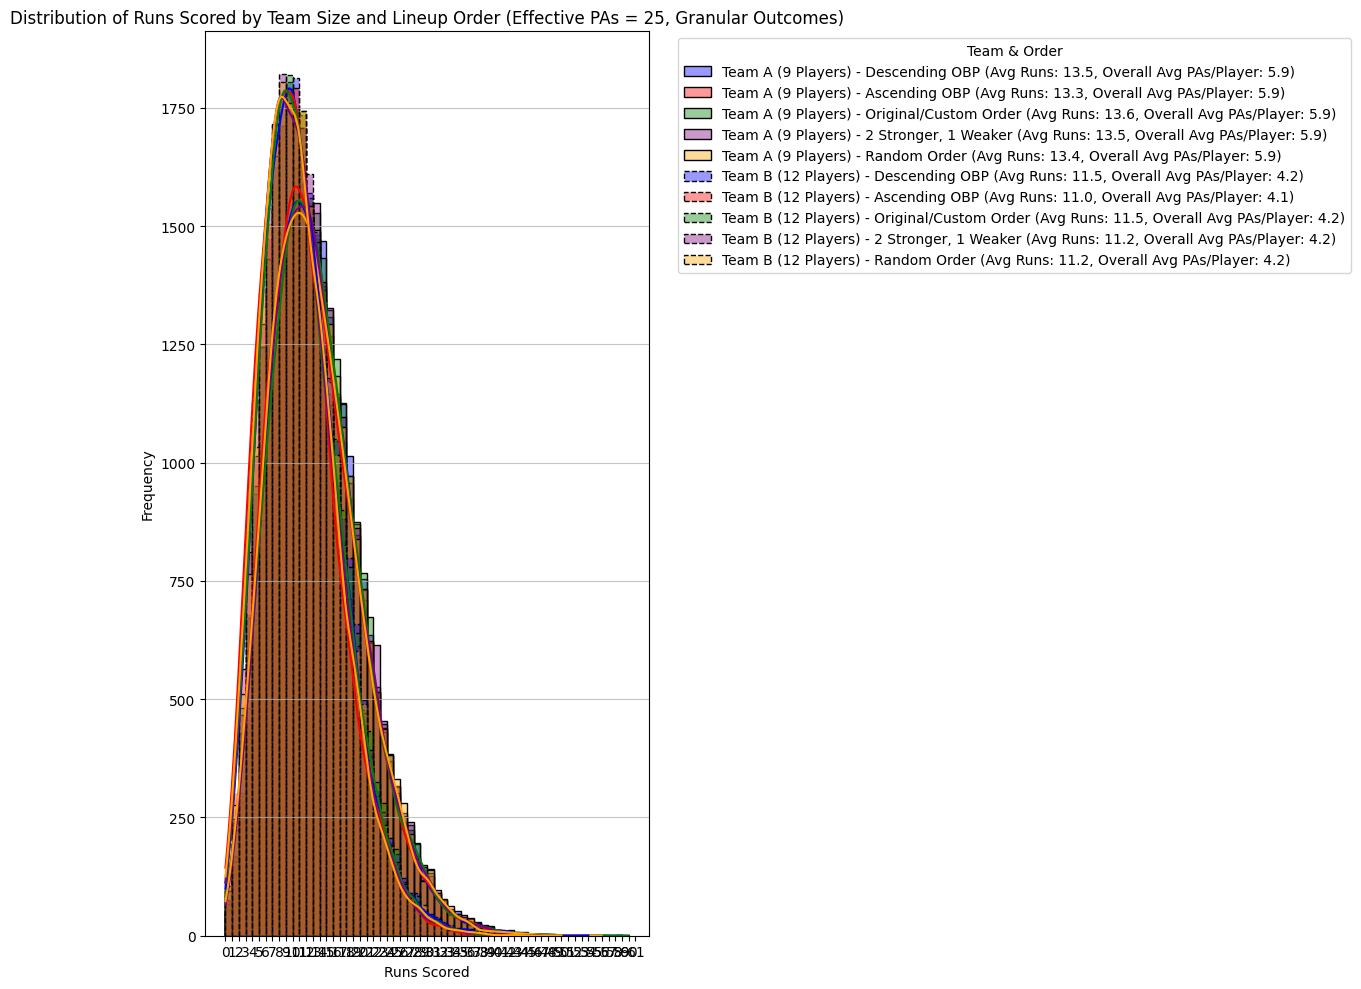

In [6]:
# --- Global Simulation Parameters ---
num_simulations = 25000 # Number of games to simulate
effective_PAs = 25     # This parameter controls the uncertainty in OBP.
                       # Lower value (e.g., 25 for kids) = more uncertainty (wider OBP distribution).
                       # Higher value (e.g., 500 for pros) = less uncertainty (tighter OBP distribution).
num_innings = 9        # Number of regulation innings per game

# --- Assumed Baseball Ratios (for deriving granular probabilities from OBP) ---
# These are rough approximations and can be adjusted based on league/age level
# Proportions of hits (sum to 1.0)
PROPORTION_1B_OF_HIT = 0.65
PROPORTION_2B_OF_HIT = 0.20
PROPORTION_3B_OF_HIT = 0.02
PROPORTION_HR_OF_HIT = 0.13

# Proportion of on-base events that are walks
PROPORTION_BB_OF_ONBASE = 0.20 # 20% of the time a player gets on base, it's a walk

# Proportion of outs that are strikeouts
PROPORTION_K_OF_OUT = 0.30 # 30% of the time a player gets out, it's a strikeout

# The OBPs for the core 9 players (your original lineup A)
core_9_players_obps = [
    0.545, 0.545, 0.538, 0.5, 0.462, 0.455, 0.455, 0.455, 0.429,
]

# The OBPs for the 3 additional players (lower OBP as specified)
additional_3_players_obps = [0.4, 0.364, 0.333]

team_A_base_lineup_obps = core_9_players_obps
team_B_base_lineup_obps = core_9_players_obps + additional_3_players_obps

opponent_lineup_obps_nominal = list(core_9_players_obps)

# --- Helper to get granular probabilities from a nominal OBP ---
def get_player_probabilities(nominal_obp):
    """
    Derives granular batting probabilities (1B, 2B, 3B, HR, BB, K, OUT_OTHER)
    from a nominal OBP using predefined ratios.
    """
    p_on_base = nominal_obp
    p_out = 1.0 - nominal_obp

    # Distribute on-base events
    p_bb = p_on_base * PROPORTION_BB_OF_ONBASE
    p_hit = p_on_base - p_bb

    p_1b = p_hit * PROPORTION_1B_OF_HIT
    p_2b = p_hit * PROPORTION_2B_OF_HIT
    p_3b = p_hit * PROPORTION_3B_OF_HIT
    p_hr = p_hit * PROPORTION_HR_OF_HIT

    # Distribute outs
    p_k = p_out * PROPORTION_K_OF_OUT
    p_out_other = p_out - p_k

    # Ensure probabilities sum to 1 (due to floating point, might be slightly off)
    total_prob = p_1b + p_2b + p_3b + p_hr + p_bb + p_k + p_out_other
    if not np.isclose(total_prob, 1.0):
        # Normalize if necessary
        scaling_factor = 1.0 / total_prob
        p_1b *= scaling_factor
        p_2b *= scaling_factor
        p_3b *= scaling_factor
        p_hr *= scaling_factor
        p_bb *= scaling_factor
        p_k *= scaling_factor
        p_out_other *= scaling_factor

    return {
        '1B': p_1b, '2B': p_2b, '3B': p_3b, 'HR': p_hr,
        'BB': p_bb, 'K': p_k, 'OUT_OTHER': p_out_other
    }

# --- 2. Define Different Lineup Orderings for Each Team Size ---
def get_lineup_orderings(base_obps):
    """Generates different lineup orderings for a given set of player OBPs."""
    sorted_obps_desc = sorted(base_obps, reverse=True)
    sorted_obps_asc = sorted(base_obps)
    
    custom_order = list(base_obps) 

    lineup_2s1w = []
    available_players = sorted(base_obps, reverse=True) 
    
    while available_players:
        for _ in range(min(2, len(available_players))):
            lineup_2s1w.append(available_players.pop(0)) 
        if available_players:
            lineup_2s1w.append(available_players.pop(-1)) 
    
    return {
        "Descending OBP": sorted_obps_desc,
        "Ascending OBP": sorted_obps_asc,
        "Original/Custom Order": custom_order,
        "2 Stronger, 1 Weaker": lineup_2s1w,
        "Random Order": list(base_obps) # Base list to be shuffled per game
    }

team_A_lineup_options = get_lineup_orderings(team_A_base_lineup_obps)
team_B_lineup_options = get_lineup_orderings(team_B_base_lineup_obps)

all_team_lineup_options = {
    "Team A (9 Players)": team_A_lineup_options,
    "Team B (12 Players)": team_B_lineup_options
}

# --- 3. Base Running Logic (Comprehensive) ---
# This dictionary defines the new base state and runs scored for each initial
# base state and each offensive outcome.
# State format: (runner_on_1st, runner_on_2nd, runner_on_3rd)
# Outcome format: (new_r1, new_r2, new_r3), runs_scored

BASE_RUNNING_RULES = {
    (0,0,0): { # Bases Empty
        '1B': ((1,0,0), 0), '2B': ((0,1,0), 0), '3B': ((0,0,1), 0), 'HR': ((0,0,0), 1), 'BB': ((1,0,0), 0)
    },
    (1,0,0): { # Runner on 1st
        '1B': ((1,1,0), 0), '2B': ((0,1,0), 1), '3B': ((0,0,1), 1), 'HR': ((0,0,0), 2), 'BB': ((1,1,0), 0)
    },
    (0,1,0): { # Runner on 2nd
        '1B': ((1,0,1), 0), '2B': ((0,1,0), 1), '3B': ((0,0,1), 1), 'HR': ((0,0,0), 2), 'BB': ((1,1,0), 0)
    },
    (0,0,1): { # Runner on 3rd
        '1B': ((1,0,0), 1), '2B': ((0,1,0), 1), '3B': ((0,0,1), 1), 'HR': ((0,0,0), 2), 'BB': ((1,0,0), 1)
    },
    (1,1,0): { # Runners on 1st, 2nd
        '1B': ((1,1,1), 0), '2B': ((0,1,0), 2), '3B': ((0,0,1), 2), 'HR': ((0,0,0), 3), 'BB': ((1,1,1), 0)
    },
    (1,0,1): { # Runners on 1st, 3rd
        '1B': ((1,1,0), 1), '2B': ((0,1,0), 2), '3B': ((0,0,1), 2), 'HR': ((0,0,0), 3), 'BB': ((1,1,0), 1)
    },
    (0,1,1): { # Runners on 2nd, 3rd
        '1B': ((1,0,1), 1), '2B': ((0,1,0), 2), '3B': ((0,0,1), 2), 'HR': ((0,0,0), 3), 'BB': ((1,1,0), 1)
    },
    (1,1,1): { # Bases Loaded
        '1B': ((1,1,1), 1), '2B': ((0,1,0), 3), '3B': ((0,0,1), 3), 'HR': ((0,0,0), 4), 'BB': ((1,1,1), 1)
    }
}

def get_next_state_and_runs(current_bases, outcome):
    """
    Determines the next base state and runs scored based on current bases and at-bat outcome.
    Assumes average runner speed and no errors/double plays for now.
    """
    if outcome in ['K', 'OUT_OTHER']:
        return current_bases, 0 # Outs don't change base state or score runs directly

    try:
        new_bases, runs = BASE_RUNNING_RULES[current_bases][outcome]
        return new_bases, runs
    except KeyError:
        print(f"Error: Missing base running rule for state {current_bases} and outcome {outcome}")
        return current_bases, 0 # Fallback to no change

# --- 4. At-Bat Simulation (Now uses granular probabilities) ---
def simulate_at_bat_granular(player_probs):
    """
    Simulates a single at-bat based on granular probabilities.
    """
    outcomes = ['1B', '2B', '3B', 'HR', 'BB', 'K', 'OUT_OTHER']
    probabilities = [player_probs[o] for o in outcomes]
    
    prob_sum = sum(probabilities)
    if not np.isclose(prob_sum, 1.0):
        probabilities = [p / prob_sum for p in probabilities]

    return np.random.choice(outcomes, p=probabilities)

# --- 5. Inning Simulation (Uses granular at-bat and robust base running) ---
def simulate_inning_granular(batting_lineup_player_probs_for_game, current_batter_idx_start_of_inning, player_pa_counts_this_game_ref):
    """
    Simulates a single half-inning for a team using granular outcomes and robust base running.
    Updates player_pa_counts_this_game_ref in place.

    Args:
        batting_lineup_player_probs_for_game (list): List of dictionaries, each containing
                                                     game-specific granular probabilities for a player.
        current_batter_idx_start_of_inning (int): The absolute index of the player currently up to bat
                                                 (relative to the start of the entire game's PAs for this team).
        player_pa_counts_this_game_ref (list): A list (passed by reference) to accumulate PAs for each batting slot.

    Returns:
        tuple: (runs_scored_this_inning, next_batter_idx, updated_player_pa_counts_this_game_ref)
    """
    runs_scored_this_inning = 0
    outs = 0
    bases = (0, 0, 0) # Use tuple for base state

    num_players_in_lineup = len(batting_lineup_player_probs_for_game)
    current_batter_idx = current_batter_idx_start_of_inning # Initialize overall PA counter for the game

    while outs < 3:
        player_slot_index = current_batter_idx % num_players_in_lineup
        player_pa_counts_this_game_ref[player_slot_index] += 1 # Increment PA for this specific batting slot

        player_probs = batting_lineup_player_probs_for_game[player_slot_index] # Get player's granular probs for this slot
        outcome = simulate_at_bat_granular(player_probs)

        if outcome in ['K', 'OUT_OTHER']:
            outs += 1
        else: # It's a hit or a walk
            new_bases, runs_this_play = get_next_state_and_runs(bases, outcome)
            bases = new_bases
            runs_scored_this_inning += runs_this_play

        current_batter_idx += 1 # Advance the overall PA counter for the game

    return runs_scored_this_inning, current_batter_idx, player_pa_counts_this_game_ref

# --- 6. Helper Function for Single Game Simulation ---
def _simulate_single_game_with_actual_obps(team_a_player_probs_for_game, team_b_player_probs_for_game, num_innings):
    """
    Simulates a single baseball game given the actual, game-specific granular probabilities for both teams.
    Returns: (Team A runs, Team B runs, Team A PAs per batter for this game, Team B PAs per batter for this game)
    """
    team_a_score = 0
    team_b_score = 0

    a_batter_idx = 0 # This will track total PAs for Team A in this game
    b_batter_idx = 0 # This will track total PAs for Team B in this game

    num_players_a = len(team_a_player_probs_for_game)
    num_players_b = len(team_b_player_probs_for_game)
    
    # Initialize PA counters for each batting slot for THIS game
    game_player_pa_counts_a = [0] * num_players_a
    game_player_pa_counts_b = [0] * num_players_b

    for _ in range(num_innings):
        # Top of the inning (Team A bats)
        runs_a, a_batter_idx, game_player_pa_counts_a = simulate_inning_granular(
            team_a_player_probs_for_game, a_batter_idx, game_player_pa_counts_a
        )
        team_a_score += runs_a

        # Bottom of the inning (Team B bats)
        runs_b, b_batter_idx, game_player_pa_counts_b = simulate_inning_granular(
            team_b_player_probs_for_game, b_batter_idx, game_player_pa_counts_b
        )
        team_b_score += runs_b

    return team_a_score, team_b_score, game_player_pa_counts_a, game_player_pa_counts_b

# --- 7. Main Simulation Loop ---
all_results = {}

print(f"\nRunning {num_simulations} simulations for each team size and lineup order...")
print(f"OBP Uncertainty modeled with effective_PAs = {effective_PAs} (reflecting lower sample size for kids).")
print(f"Games are {num_innings} innings and can end in a tie.")
print("Incorporating granular outcomes (1B, 2B, 3B, HR, BB, K, OUT_OTHER) and robust base running.")
print("Tracking total plate attempts per batter (batting slot).")


for team_label, lineup_options_for_team in all_team_lineup_options.items():
    all_results[team_label] = {}
    
    print(f"\n### Simulating for: {team_label} ###")
    base_nominal_obps_list = team_A_base_lineup_obps if "9 Players" in team_label else team_B_base_lineup_obps
    print(f"  Nominal Average OBP of Roster: {np.mean(base_nominal_obps_list):.3f}")

    for lineup_name, nominal_lineup_obps_config in lineup_options_for_team.items():
        if not nominal_lineup_obps_config:
            print(f"  Skipping {lineup_name} for {team_label} due to invalid lineup construction.")
            continue

        num_players_in_current_lineup = len(nominal_lineup_obps_config)

        team_analysed_wins = 0
        team_analysed_ties = 0 
        team_analysed_scores = []
        
        # New: Aggregate PAs for each specific batting slot across all simulations
        aggregated_pas_per_batter_slot = np.zeros(num_players_in_current_lineup)
        
        print(f"\n--- Lineup Order: {lineup_name} ---")
        for _ in range(num_simulations):
            # Step 1: Draw game-specific OBP for each player from Beta distributions
            game_lineup_analysed_player_probs = []
            for p_nominal_obp in nominal_lineup_obps_config:
                alpha = p_nominal_obp * effective_PAs + 1
                beta = (1 - p_nominal_obp) * effective_PAs + 1
                game_specific_obp = np.random.beta(alpha, beta)
                game_lineup_analysed_player_probs.append(get_player_probabilities(game_specific_obp))
            
            game_lineup_opponent_player_probs = []
            for p_nominal_obp in opponent_lineup_obps_nominal:
                alpha = p_nominal_obp * effective_PAs + 1
                beta = (1 - p_nominal_obp) * effective_PAs + 1
                game_specific_obp = np.random.beta(alpha, beta)
                game_lineup_opponent_player_probs.append(get_player_probabilities(game_specific_obp))

            # Step 2: If "Random Order", shuffle the list of player probability dictionaries (the actual lineup for this game)
            if lineup_name == "Random Order":
                random.shuffle(game_lineup_analysed_player_probs)

            # Step 3: Simulate the game
            score_analysed, score_opponent, game_pas_per_batter_slot, _ = _simulate_single_game_with_actual_obps(
                game_lineup_analysed_player_probs, 
                game_lineup_opponent_player_probs, 
                num_innings
            )
            
            team_analysed_scores.append(score_analysed)
            # Accumulate PAs for each batter slot
            aggregated_pas_per_batter_slot += np.array(game_pas_per_batter_slot)


            if score_analysed > score_opponent:
                team_analysed_wins += 1
            elif score_analysed == score_opponent: 
                team_analysed_ties += 1

        # Calculate average PAs per batter (slot) over all simulations
        average_pas_per_batter_slot = aggregated_pas_per_batter_slot / num_simulations
        # Calculate the overall average PAs per player (which is just the mean of the slot averages)
        overall_avg_pas_per_player = np.mean(average_pas_per_batter_slot)


        all_results[team_label][lineup_name] = {
            'avg_score': np.mean(team_analysed_scores),
            'median_score': np.median(team_analysed_scores),
            'win_percentage': team_analysed_wins / num_simulations,
            'tie_percentage': team_analysed_ties / num_simulations,
            'score_distribution': team_analysed_scores,
            'avg_pas_per_player_overall': overall_avg_pas_per_player, # Overall average (for table)
            'avg_pas_per_batter_slot': average_pas_per_batter_slot # Array of PAs per slot (for detailed print)
        }

        print(f"  Average Runs Scored: {all_results[team_label][lineup_name]['avg_score']:.2f}")
        print(f"  Win Percentage: {all_results[team_label][lineup_name]['win_percentage']:.2%}")
        print(f"  Tie Percentage: {all_results[team_label][lineup_name]['tie_percentage']:.2%}")
        print(f"  Overall Avg PAs per Player: {all_results[team_label][lineup_name]['avg_pas_per_player_overall']:.2f}")
        print(f"  Avg PAs per Batting Slot: {', '.join(f'{pa:.2f}' for pa in all_results[team_label][lineup_name]['avg_pas_per_batter_slot'])}")
        print(f"  Nominal OBP Lineup: {', '.join(f'{o:.3f}' for o in nominal_lineup_obps_config)}")


# --- Display Comprehensive Comparative Results in a Table ---
print("\n\n--- Comprehensive Comparative Results (with Granular Outcomes & OBP Uncertainty) ---")
print("{:<25} {:<18} {:<15} {:<12} {:<12} {:<15}".format("Team & Lineup Order", "Nominal Avg OBP", "Avg Runs", "Win %", "Tie %", "Overall Avg PAs/Player"))
print("-" * 105)

for team_label, team_results in all_results.items():
    for lineup_name, data in team_results.items():
        if not data: 
            continue
        current_lineup_obps_nominal = all_team_lineup_options[team_label][lineup_name]
        nominal_lineup_avg_obp = np.mean(current_lineup_obps_nominal)

        print("{:<25} {:<18.3f} {:<15.2f} {:<12.2%} {:<12.2%} {:<15.2f}".format(
            f"{team_label} ({lineup_name})",
            nominal_lineup_avg_obp,
            data['avg_score'],
            data['win_percentage'],
            data['tie_percentage'],
            data['avg_pas_per_player_overall']
        ))
    # Add a separator between teams for readability
    if team_label == "Team A (9 Players)":
        print("-" * 105)


# --- Visualize Results ---
plt.figure(figsize=(16, 10))
plot_colors = {'Descending OBP': 'blue', 'Ascending OBP': 'red', 'Original/Custom Order': 'green', '2 Stronger, 1 Weaker': 'purple', 'Random Order': 'orange'}
plot_line_styles = {'Team A (9 Players)': '-', 'Team B (12 Players)': '--'}

for team_label, team_data in all_results.items():
    for lineup_name, data in team_data.items():
        if not data: 
            continue
        label = (f"{team_label} - {lineup_name} (Avg Runs: {data['avg_score']:.1f}, "
                 f"Overall Avg PAs/Player: {data['avg_pas_per_player_overall']:.1f})")
        sns.histplot(data['score_distribution'], kde=True, alpha=0.4, binwidth=1,
                     color=plot_colors[lineup_name], linestyle=plot_line_styles[team_label],
                     label=label)

plt.title(f'Distribution of Runs Scored by Team Size and Lineup Order (Effective PAs = {effective_PAs}, Granular Outcomes)')
plt.xlabel('Runs Scored')
plt.ylabel('Frequency')
plt.legend(title="Team & Order", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.75)
min_score = min(min(res['score_distribution']) for team_res in all_results.values() for res in team_res.values() if res)
max_score = max(max(res['score_distribution']) for team_res in all_results.values() for res in team_res.values() if res)
plt.xticks(range(int(min_score), int(max_score) + 2))
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()